In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# todo split male female




In [78]:
from sklearn.metrics import confusion_matrix

def confusion(y_val, y_pred):
    # Assuming y_val and y_pred are defined
    cm = confusion_matrix(y_val, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def prediction_finale(modelS, modelP, X_trainS, y_trainS, X_trainP, y_trainP, X_testS, id_testS, X_testP, id_testP, oversamplingS = False, oversamplingP = False, threshold=0.5):
    if oversamplingS:
        smote = SMOTE()
        X_trainS, y_trainS = smote.fit_resample(X_trainS, y_trainS)
    if oversamplingP:
        smote = SMOTE()
        X_trainP, y_trainP = smote.fit_resample(X_trainP, y_trainP)
    X_testS = X_testS.fillna(X_testS.median())
    X_testP = X_testP.fillna(X_testP.median())
    modelS.fit(X_trainS, y_trainS)
    modelP.fit(X_trainP, y_trainP)
    y_predS = modelS.predict(X_testS)
    y_predP = modelP.predict(X_testP)
    # y_predS = (y_predS > threshold).astype(int)
    # y_predP = (y_predP > threshold).astype(int)
    subS = pd.DataFrame({'id': id_testS, 'Depression': y_predS})
    subP = pd.DataFrame({'id': id_testP, 'Depression': y_predP})

    sub = pd.concat([subS, subP], axis=0)
    sub = sub.sort_values(by='id')
    sub.to_csv('submission.csv', index=False)
    

def test_model(modelS, modelP, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS = False, oversamplingP = False):
    if oversamplingS:
        smote = SMOTE()
        X_trainS, y_trainS = smote.fit_resample(X_trainS, y_trainS)
    if oversamplingP:
        smote = SMOTE()
        X_trainP, y_trainP = smote.fit_resample(X_trainP, y_trainP)
    X_trainS, X_valS, y_trainS, y_valS = train_test_split(X_trainS, y_trainS, test_size=0.2, random_state=42)
    X_trainP, X_valP, y_trainP, y_valP = train_test_split(X_trainP, y_trainP, test_size=0.2, random_state=42)
    modelS.fit(X_trainS, y_trainS)
    modelP.fit(X_trainP, y_trainP)
    y_predS = modelS.predict(X_valS)
    y_predP = modelP.predict(X_valP)
    print('Model S')
    print('Accuracy:', accuracy_score(y_valS, y_predS))
    print('Balanced accuracy:', balanced_accuracy_score(y_valS, y_predS))
    print('AUC:', roc_auc_score(y_valS, y_predS))
    print('Model P')
    print('Accuracy:', accuracy_score(y_valP, y_predP))
    print('Balanced accuracy:', balanced_accuracy_score(y_valP, y_predP))
    print('AUC:', roc_auc_score(y_valP, y_predP))
    # confusion(y_valS, y_predS)
    # confusion(y_valP, y_predP)

    y_pred = np.concatenate((y_predS, y_predP))
    y_val = np.concatenate((y_valS, y_valP))
    print('Combined')
    print('Accuracy:', accuracy_score(y_val, y_pred))
    print('Balanced accuracy:', balanced_accuracy_score(y_val, y_pred))
    print('AUC:', roc_auc_score(y_val, y_pred)) 

    

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [49]:
def preprocess_all_data(train, test, split=False):


    X_train = train.drop('Depression', axis=1)
    y_train = train['Depression']
    X = pd.concat([X_train, test], axis=0)
    len_train = len(X_train)
    len_test = len(test)
    len_X = len(X)
    print('len_train:', len_train)
    print('len_test:', len_test)
    print('len_X:', len_X)


    if split:




        X = X.drop(['Name'], axis=1)
        X['Pressure'] = X[['Work Pressure', 'Academic Pressure']].max(axis=1)
        X = X.drop(['Work Pressure', 'Academic Pressure'], axis=1)
        X['Gender'] = (X['Gender'] == 'Male').astype(int)
        X.loc[X['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
        X['Satisfaction'] = X[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)
        X = X.drop(['Study Satisfaction', 'Job Satisfaction'], axis=1)
        X['Family History of Mental Illness'] = (X['Family History of Mental Illness'] == 'Yes').astype(int)
        X['Have you ever had suicidal thoughts ?'] = (X['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)


        X = X.drop(['City'], axis=1)


        # v = X["City"].value_counts() 
        # tmp = X[X['City'].isin(v.index[v.gt(10)])]
        # tmp = pd.get_dummies(tmp, columns=['City'])
        # tmp_cols = [col for col in tmp.columns if col.startswith('City_')]
        # X = pd.get_dummies(X, columns=['City'])
        # City_cols = [col for col in X.columns if col.startswith('City_')]
        # X[City_cols] = X[City_cols].astype(int)
        # X = X.drop(tmp_cols, axis=1)



        diet_mapping = {'Moderate': 1.0, 'Unhealthy': 0.0, 'Healthy': 2.0}
        X['Dietary Habits'] = X['Dietary Habits'].map(diet_mapping)
        v = X["Profession"].value_counts() 

        X = pd.get_dummies(X, columns=['Profession'])
        profession_cols = [col for col in X.columns if col.startswith('Profession_')]
        X[profession_cols] = X[profession_cols].astype(int)
        X = X.drop(['Working Professional or Student'], axis=1)
        v = X["Degree"].value_counts() 
        X = pd.get_dummies(X, columns=['Degree'])
        degree_cols = [col for col in X.columns if col.startswith('Degree_')]
        X[degree_cols] = X[degree_cols].astype(int)
        dict_sleep = {'Less than 5 hours': 4.0, '5-6 hours': 5.5, '6-7 hours': 6.5, '7-8 hours': 7.5, 'More than 8 hours': 9.0, '2-3 hours': 2.5, '3-4 hours': 3.5, '4-5 hours': 4.5, '4-6 hours': 5.0}
        X['Sleep Duration'] = X['Sleep Duration'].map(dict_sleep)
        X['CGPA'] = X['CGPA'].fillna(X['CGPA'].mean())

        X_train = X[:len_train]
        X_test = X[len_train:]

        X_trainS = X_train[X_train['Profession_Student'] == 1]
        X_trainP = X_train[X_train['Profession_Student'] == 0]
        X_trainP = X_trainP.drop(['Profession_Student'], axis=1)
        X_trainP = X_trainP.drop(['CGPA'], axis=1)
        X_trainS = X_trainS.drop(profession_cols, axis=1)

        X_testS = X_test[X_test['Profession_Student'] == 1]
        X_testP = X_test[X_test['Profession_Student'] == 0]
        X_testP = X_testP.drop(['Profession_Student'], axis=1)
        X_testP = X_testP.drop(['CGPA'], axis=1)
        X_testS = X_testS.drop(profession_cols, axis=1)
        

        y_trainS = y_train[X_trainS.index]
        y_trainP = y_train[X_trainP.index]

        id_testS = X_testS['id']
        id_testP = X_testP['id']
        X_trainS = X_trainS.drop(['id'], axis=1)
        X_trainP = X_trainP.drop(['id'], axis=1)
        X_testS = X_testS.drop(['id'], axis=1)
        X_testP = X_testP.drop(['id'], axis=1)

        


        return X_trainS, y_trainS, X_trainP, y_trainP, X_testS, id_testS, X_testP, id_testP



    else :
        X = X.drop(['id', 'Name'], axis=1)
        X['Pressure'] = X[['Work Pressure', 'Academic Pressure']].max(axis=1)
        X = X.drop(['Work Pressure', 'Academic Pressure'], axis=1)
        X['Gender'] = (X['Gender'] == 'Male').astype(int)
        X.loc[X['Working Professional or Student'] == 'Student', 'Profession'] = 'Student'
        X['Satisfaction'] = X[['Study Satisfaction', 'Job Satisfaction']].max(axis=1)
        X = X.drop(['Study Satisfaction', 'Job Satisfaction'], axis=1)
        X['Family History of Mental Illness'] = (X['Family History of Mental Illness'] == 'Yes').astype(int)
        X['Have you ever had suicidal thoughts ?'] = (X['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)


        X = X.drop(['City'], axis=1)


        # v = X["City"].value_counts() 
        # tmp = X[X['City'].isin(v.index[v.gt(10)])]
        # tmp = pd.get_dummies(tmp, columns=['City'])
        # tmp_cols = [col for col in tmp.columns if col.startswith('City_')]
        # X = pd.get_dummies(X, columns=['City'])
        # City_cols = [col for col in X.columns if col.startswith('City_')]
        # X[City_cols] = X[City_cols].astype(int)
        # X = X.drop(tmp_cols, axis=1)



        diet_mapping = {'Moderate': 1.0, 'Unhealthy': 0.0, 'Healthy': 2.0}
        X['Dietary Habits'] = X['Dietary Habits'].map(diet_mapping)
        v = X["Profession"].value_counts() 

        X = pd.get_dummies(X, columns=['Profession'])
        profession_cols = [col for col in X.columns if col.startswith('Profession_')]
        X[profession_cols] = X[profession_cols].astype(int)
        X = X.drop(['Working Professional or Student'], axis=1)
        v = X["Degree"].value_counts() 
        X = pd.get_dummies(X, columns=['Degree'])
        degree_cols = [col for col in X.columns if col.startswith('Degree_')]
        X[degree_cols] = X[degree_cols].astype(int)
        dict_sleep = {'Less than 5 hours': 4.0, '5-6 hours': 5.5, '6-7 hours': 6.5, '7-8 hours': 7.5, 'More than 8 hours': 9.0, '2-3 hours': 2.5, '3-4 hours': 3.5, '4-5 hours': 4.5, '4-6 hours': 5.0}
        X['Sleep Duration'] = X['Sleep Duration'].map(dict_sleep)
        X['CGPA'] = X['CGPA'].fillna(X['CGPA'].mean())

        X_train = X[:len_train]
        X_test = X[len_train:]


        return X_train, X_test, y_train
    



In [50]:
X_trainS, y_trainS, X_trainP, y_trainP, X_testS, id_testS, X_testP, id_testP = preprocess_all_data(train, test, split=True)

train_S = pd.concat([X_trainS, y_trainS], axis=1)
train_S = train_S.dropna()
X_trainS = train_S.drop('Depression', axis=1)
y_trainS = train_S['Depression']

train_P = pd.concat([X_trainP, y_trainP], axis=1)
train_P = train_P.dropna()
X_trainP = train_P.drop('Depression', axis=1)
y_trainP = train_P['Depression']

# X_trainS2, X_valS, y_trainS2, y_valS = train_test_split(X_trainS, y_trainS, test_size=0.2, random_state=42)
# X_trainP2, X_valP, y_trainP2, y_valP = train_test_split(X_trainP, y_trainP, test_size=0.2, random_state=42)

len_train: 140700
len_test: 93800
len_X: 234500


Model S
Accuracy: 0.8755936877585414
Balanced accuracy: 0.8756027693164574
AUC: 0.8756027693164575
Model P
Accuracy: 0.9770059417419449
Balanced accuracy: 0.9770111313427599
AUC: 0.9770111313427597


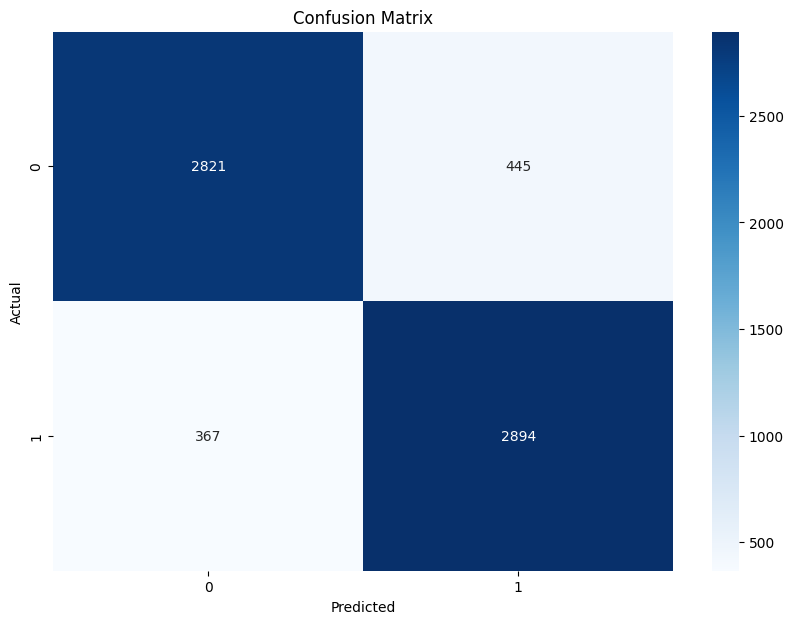

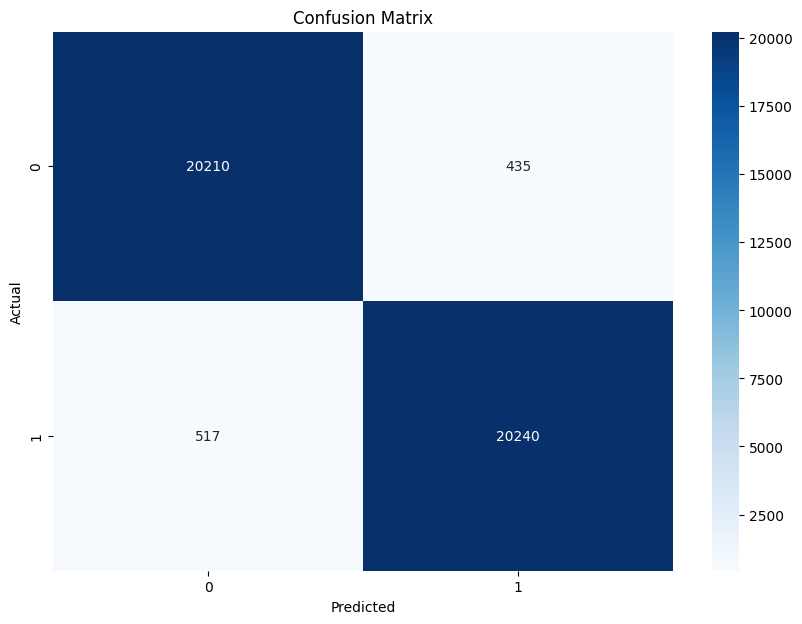

In [69]:
# GradientBoostingClassifier {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 1.0}
gb1 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split=4, subsample=1.0, random_state=42)
gb2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split=4, subsample=1.0, random_state=42)



test_model(gb1, gb2, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=True, oversamplingP=True)

Model S
Accuracy: 0.8466367713004485
Balanced accuracy: 0.8391599885083081
AUC: 0.8391599885083081
Model P
Accuracy: 0.9607025636476537
Balanced accuracy: 0.8371604536198967
AUC: 0.8371604536198967


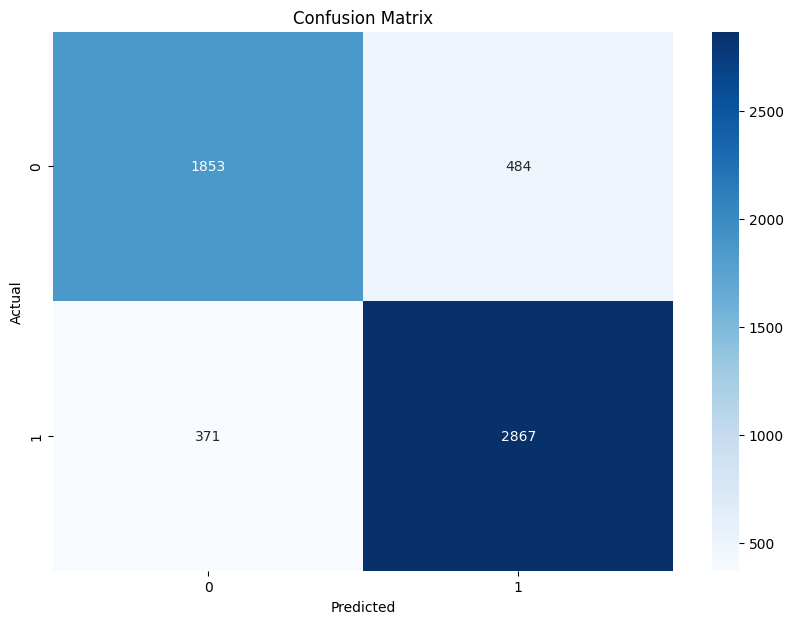

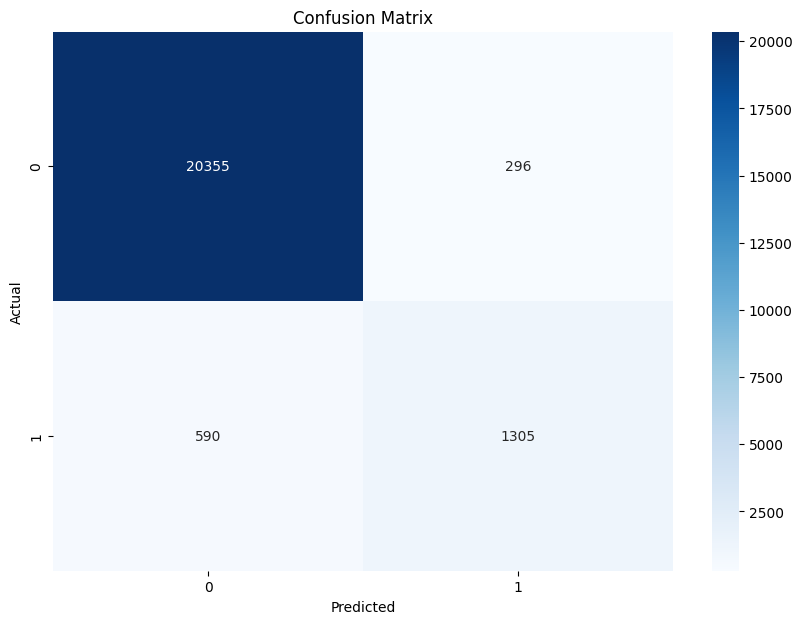

In [70]:
gb1 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split=4, subsample=1.0, random_state=42)
gb2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split=4, subsample=1.0, random_state=42)

test_model(gb1, gb2, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=False, oversamplingP=False)

GradientBoostingClassifier avec oversampling
Model S
Accuracy: 0.8746744292937031
Balanced accuracy: 0.8746837450445644
AUC: 0.8746837450445644
Model P
Accuracy: 0.9764745664460655
Balanced accuracy: 0.97647896807927
AUC: 0.97647896807927


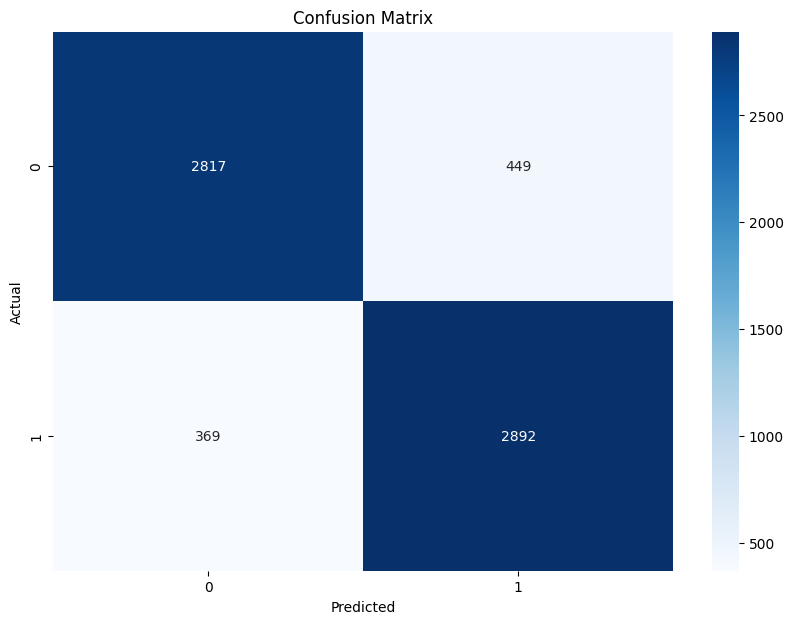

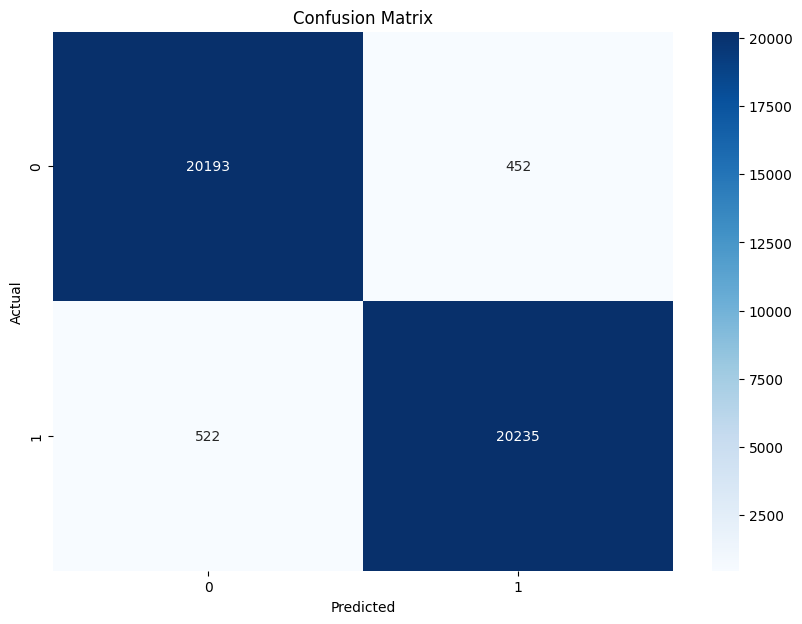

GradientBoostingClassifier sans oversampling
Model S
Accuracy: 0.8450224215246637
Balanced accuracy: 0.837948841355713
AUC: 0.837948841355713
Model P
Accuracy: 0.9607025636476537
Balanced accuracy: 0.8371604536198967
AUC: 0.8371604536198967


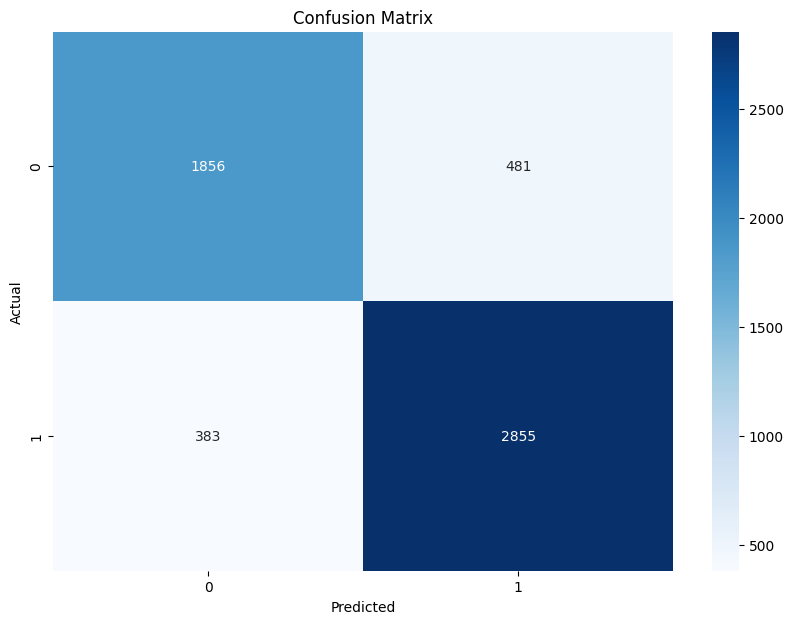

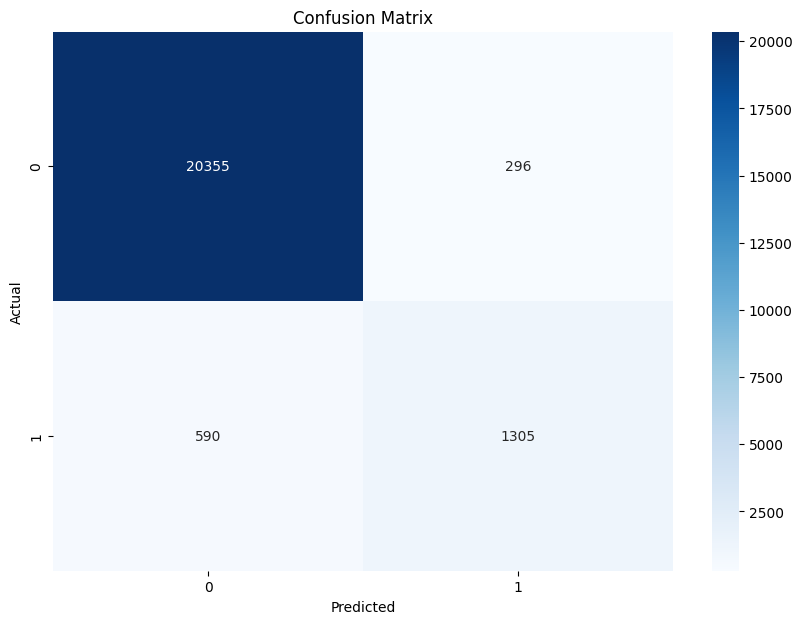

In [74]:
gb_S = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split=4, subsample=1.0, random_state=42)
gb_P = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, max_depth=3, min_samples_split=4, subsample=1.0, random_state=42)

# Avec oversampling
print('GradientBoostingClassifier avec oversampling')
test_model(gb_S, gb_P, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=True, oversamplingP=True)

# Sans oversampling
print('GradientBoostingClassifier sans oversampling')
test_model(gb_S, gb_P, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=False, oversamplingP=False)


Model S
Accuracy: 0.8754404780144017
Balanced accuracy: 0.8754492073838174
AUC: 0.8754492073838173
Model P
Accuracy: 0.9756291966571663
Balanced accuracy: 0.9756320892858724
AUC: 0.9756320892858724


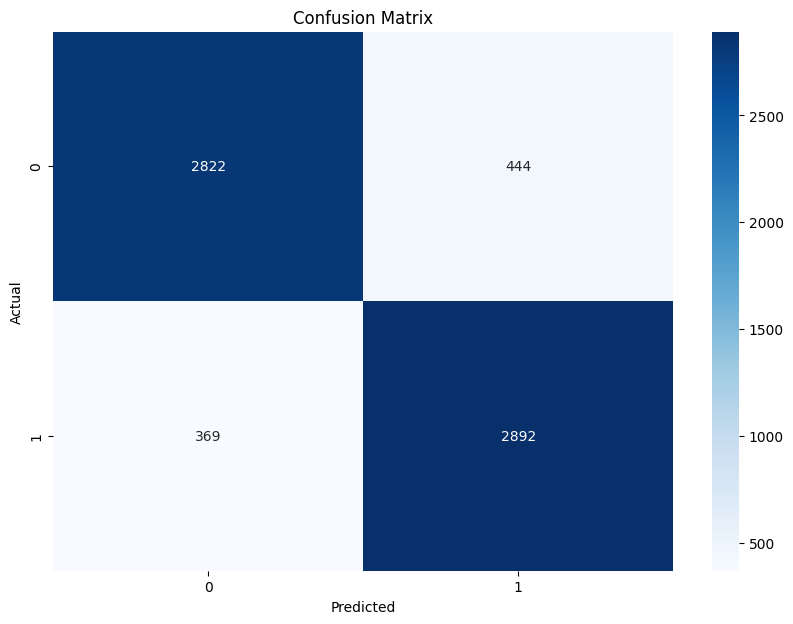

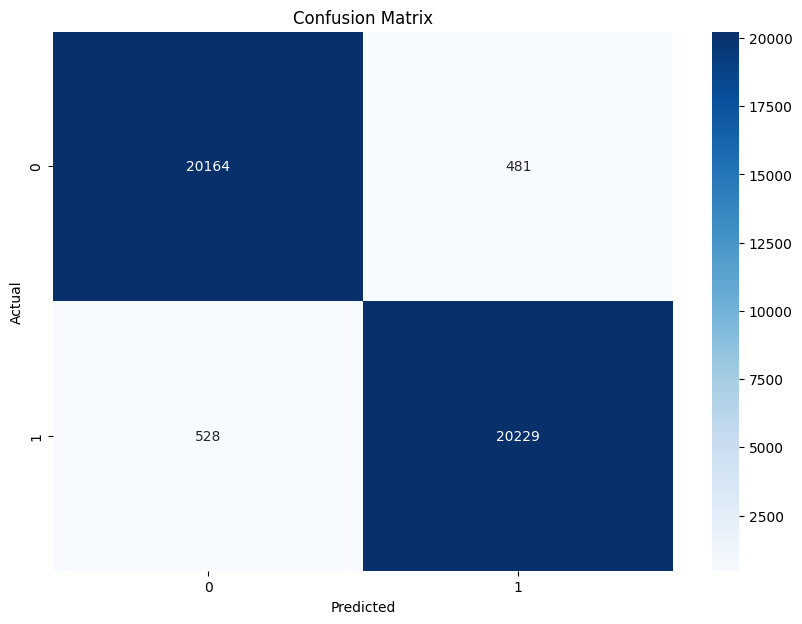

Model S
Accuracy: 0.8419730941704036
Balanced accuracy: 0.834371232922693
AUC: 0.8343712329226931
Model P
Accuracy: 0.9603920872882108
Balanced accuracy: 0.8357927686010338
AUC: 0.8357927686010338


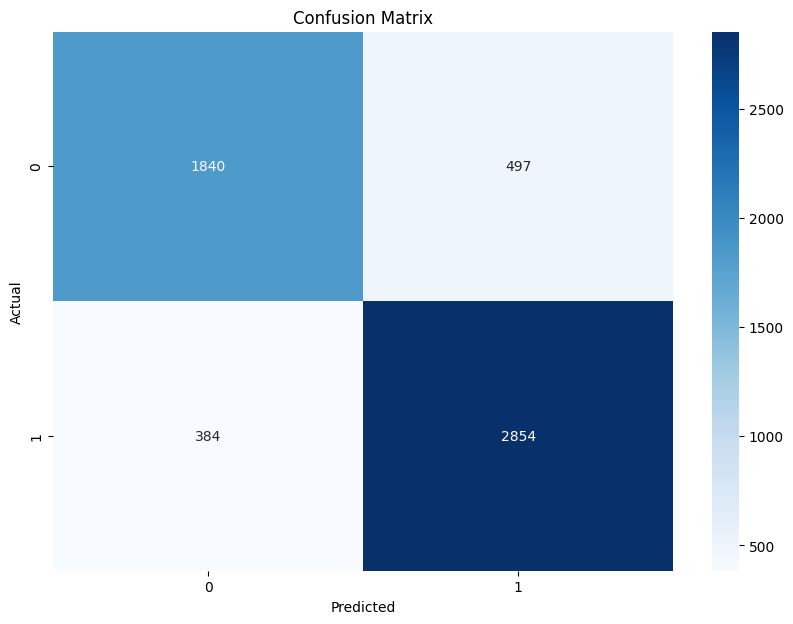

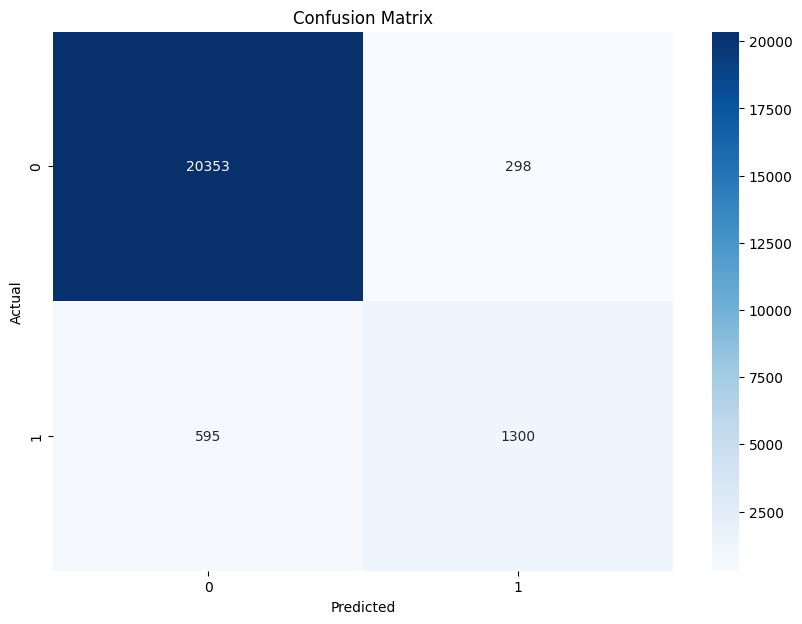

In [73]:
# XGboost {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic'}
xgb_S = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=200, objective='binary:logistic')
xgb_P = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=200, objective='binary:logistic')

# Avec oversampling
print('XGboost avec oversampling')
test_model(xgb_S, xgb_P, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=True, oversamplingP=True)

# Sans oversampling
print('XGboost sans oversampling')
test_model(xgb_S, xgb_P, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=False, oversamplingP=False)

In [80]:
logregS= LogisticRegression(C=1, max_iter=100, penalty ='l1', solver = 'liblinear')
logregP= LogisticRegression(C=1, max_iter=100, penalty ='l1', solver = 'liblinear')

test_model(logregS, logregP, X_trainS, y_trainS, X_trainP, y_trainP, oversamplingS=False, oversamplingP=False)

Model S
Accuracy: 0.846457399103139
Balanced accuracy: 0.8384697733879585
AUC: 0.8384697733879586
Model P
Accuracy: 0.9603033797569414
Balanced accuracy: 0.8331083010539908
AUC: 0.8331083010539908
Combined
Accuracy: 0.9377333665232389
Balanced accuracy: 0.8886018797498291
AUC: 0.8886018797498291


In [42]:
logreg = LogisticRegression(C=1, max_iter=100, penalty ='l1', solver = 'liblinear')
logreg.fit(X_trainS, y_trainS)
y_predS = logreg.predict(X_valS)
print('Accuracy for students:', accuracy_score(y_valS, y_predS))

logreg.fit(X_trainP, y_trainP)
y_predP = logreg.predict(X_valP)
print('Accuracy for professionals:', accuracy_score(y_valP, y_predP))

Accuracy for students: 0.846457399103139
Accuracy for professionals: 0.9607469174132884


In [31]:
estimators = [('gb', gb), ('logreg', logreg)]
vote = VotingClassifier(estimators=estimators, voting='soft')
vote.fit(X_trainS2, y_trainS2)
y_predS = vote.predict(X_valS)
print('Accuracy:', accuracy_score(y_valS, y_predS))

Accuracy: 0.8471748878923767


0:	learn: 0.6281241	total: 52.8ms	remaining: 10.5s
100:	learn: 0.3362596	total: 326ms	remaining: 320ms
199:	learn: 0.3219996	total: 575ms	remaining: 0us
Accuracy: 0.8469955156950673


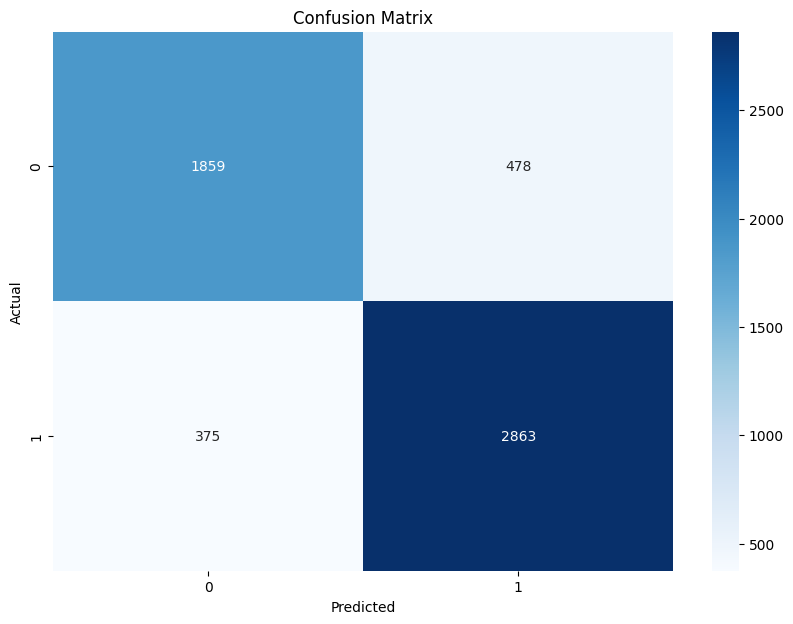

0:	learn: 0.5185673	total: 5.38ms	remaining: 1.07s
100:	learn: 0.0983075	total: 751ms	remaining: 736ms
199:	learn: 0.0944402	total: 1.47s	remaining: 0us
Accuracy: 0.9604364410538455


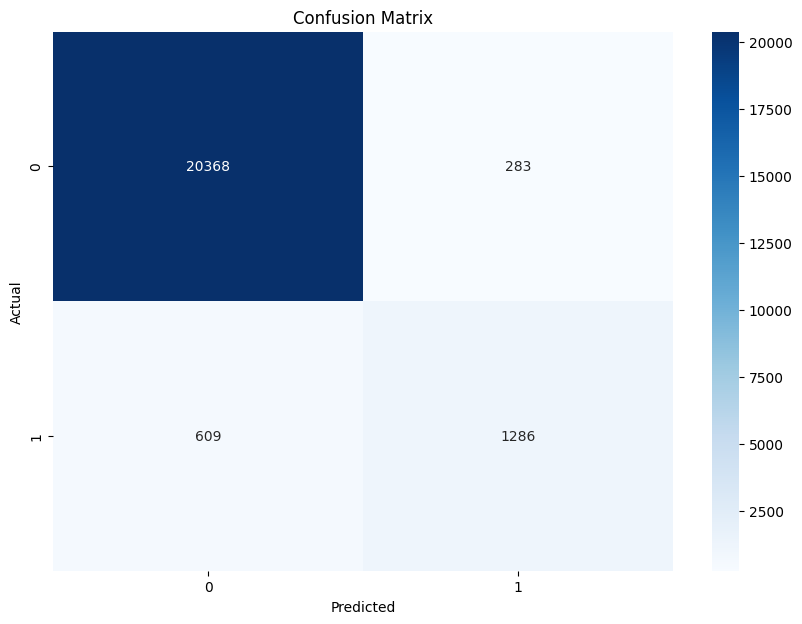

In [32]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Define the CatBoost classifier
catboost = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1, loss_function='Logloss', verbose=100, l2_leaf_reg= 1)

# Fit the model
catboost.fit(X_trainS2, y_trainS2)
y_predS = catboost.predict(X_valS)
print('Accuracy:', accuracy_score(y_valS, y_predS))
# Confusion Matrix
confusion(y_valS, y_predS)

# Define the CatBoost classifier
catboost = CatBoostClassifier(iterations=200, depth=5, learning_rate=0.1, loss_function='Logloss', verbose=100, l2_leaf_reg= 1)
catboost.fit(X_trainP2, y_trainP2)
y_predP = catboost.predict(X_valP)
print('Accuracy:', accuracy_score(y_valP, y_predP))
# Confusion Matrix
confusion(y_valP, y_predP)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=1, n_neurons=30, learning_rate=3e-3, epochs=10, batch_size=32):
        self.n_hidden = n_hidden
        self.n_neurons = n_neurons
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    
    def create_model(self, input_shape):
        model = Sequential()
        model.add(Dense(self.n_neurons, activation='relu', input_shape=input_shape))
        
        for _ in range(self.n_hidden):
            model.add(Dense(self.n_neurons, activation='relu'))
            
        model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model
    
    def fit(self, X, y):
        # Create new model instance for each fit
        self.model = self.create_model(input_shape=[X.shape[1]])
        
        # Reshape y if needed
        y = np.array(y)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        # Fit the model
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )
        return self
    
    def predict(self, X):
        predictions = self.model.predict(X, verbose=0)
        return (predictions > 0.5).astype(int).ravel()
    
    def predict_proba(self, X):
        predictions = self.model.predict(X, verbose=0)
        return np.hstack([1 - predictions, predictions])

# Create model instance
model = KerasClassifierWrapper()

# Define the parameter grid
grid_params = {
    'n_hidden': [1, 2, 3],
    'n_neurons': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.3],
    'epochs': [10, 20],
    'batch_size': [10, 20]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=grid_params,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)



# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best parameters and best score
best_params = grid_search.best_params_

print('Best Parameters:', best_params)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_pred))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# import gradient boosting and xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

# Define the model creation function
def create_model(input_shape):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=input_shape))
    for _ in range(1):
        model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

input_shape = [X_train2.shape[1]]
model = create_model(input_shape)

# Train the model
history = model.fit(X_train2, y_train2, epochs=10, batch_size=10, validation_split=0.2)

# XGBoost Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'objective': 'binary:logistic'}
xgb = XGBClassifier(learning_rate=0.3, max_depth=3, n_estimators=200, objective='binary:logistic')

# Best Gradient Boosting parameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 200, 'subsample': 1.0}
gb = GradientBoostingClassifier(learning_rate=0.3, max_depth=3, min_samples_split=4, n_estimators=200, subsample=1.0)


# Stacking Classifier tensor flow, xgboost, gradient boosting

estimators = [('model', model), ('xgb', xgb), ('gb', gb)]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train2, y_train2)
y_pred = stack.predict(X_val)
print('Accuracy:', accuracy_score(y_val, y_pred))

In [ ]:
# todo : faire un tableau avec/sans PCA